In [2]:
# Exact Diagonalization
import numpy as np
from numpy import kron
from scipy.linalg import eigh

# Pauli matrices
I = np.eye(2)
sx = np.array([[0, 1], [1, 0]])
sz = np.array([[1, 0], [0, -1]])

def op_on_site(op, site, N):
    """Place single-qubit operator on site"""
    ops = [I]*N
    ops[site] = op
    result = ops[0]
    for o in ops[1:]:
        result = kron(result, o)
    return result

def two_site_op(op1, i, op2, j, N):
    ops = [I]*N
    ops[i] = op1
    ops[j] = op2
    result = ops[0]
    for o in ops[1:]:
        result = kron(result, o)
    return result

def tfim_hamiltonian(h, N=4):
    H = np.zeros((2**N, 2**N))

    # ZZ interaction
    for i in range(N-1):
        H -= two_site_op(sz, i, sz, i+1, N)

    # Transverse field
    for i in range(N):
        H -= h * op_on_site(sx, i, N)

    return H

In [3]:
# Computing Observables
hs = np.linspace(0, 2, 50)

E0, gap, Mz = [], [], []

N = 4

for h in hs:
    H = tfim_hamiltonian(h, N)
    evals, evecs = eigh(H)

    E0.append(evals[0])
    gap.append(evals[1] - evals[0])

    psi0 = evecs[:, 0]

    mz = 0
    for i in range(N):
        mz += psi0.conj().T @ op_on_site(sz, i, N) @ psi0
    Mz.append(np.real(mz) / N)

In [4]:
print("h    Ground Energy    Gap     Magnetization")
for i in range(0, len(hs), 10):
    print(f"{hs[i]:.2f}  {E0[i]:.4f}        {gap[i]:.4f}    {Mz[i]:.4f}")

h    Ground Energy    Gap     Magnetization
0.00  -3.0000        0.0000    1.0000
0.41  -3.2759        0.0464    -0.0000
0.82  -4.1926        0.4220    -0.0000
1.22  -5.5167        1.0706    -0.0000
1.63  -6.9931        1.8130    -0.0000


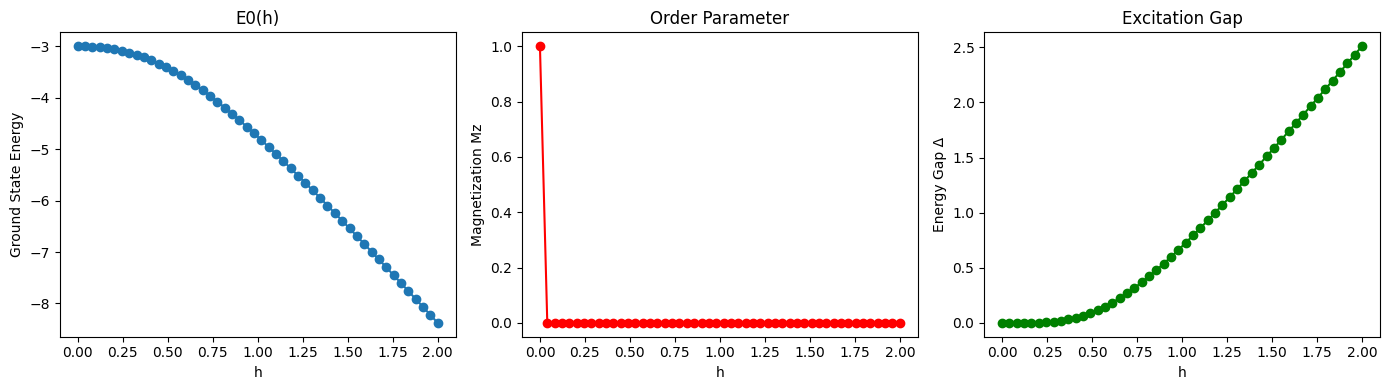

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,4))

# Ground state energy
plt.subplot(1,3,1)
plt.plot(hs, E0, 'o-')
plt.xlabel("h")
plt.ylabel("Ground State Energy")
plt.title("E0(h)")

# Magnetization
plt.subplot(1,3,2)
plt.plot(hs, Mz, 'o-', color='red')
plt.xlabel("h")
plt.ylabel("Magnetization Mz")
plt.title("Order Parameter")

# Energy gap
plt.subplot(1,3,3)
plt.plot(hs, gap, 'o-', color='green')
plt.xlabel("h")
plt.ylabel("Energy Gap Δ")
plt.title("Excitation Gap")

plt.tight_layout()
plt.show()

In [129]:
import numpy as np
from scipy.linalg import eigh
from itertools import product

In [138]:
import numpy as np

def kron_list(ops):
    """Kronecker product of a list of operators."""
    out = ops[0]
    for op in ops[1:]:
        out = np.kron(out, op)
    return out

In [139]:
def exact_tfim(N, J, h):
    dim = 2**N
    H = np.zeros((dim, dim))

    # Pauli matrices
    sx = np.array([[0, 1], [1, 0]])
    sz = np.array([[1, 0], [0, -1]])
    I = np.eye(2)

    def kron_list(ops):
        out = ops[0]
        for op in ops[1:]:
            out = np.kron(out, op)
        return out

    # ZZ term
    for i in range(N - 1):
        ops = [I]*N
        ops[i] = sz
        ops[i+1] = sz
        H -= J * kron_list(ops)

    # X term
    for i in range(N):
        ops = [I]*N
        ops[i] = sx
        H -= h * kron_list(ops)

    return H

In [147]:
Mz_exact = []

for h in hs:
    H = exact_tfim(N, J, h)
    eigvals, eigvecs = eigh(H)
    gs = eigvecs[:, 0]

    corr = 0.0
    for i in range(N):
        for j in range(N):
            ops = [np.eye(2)] * N
            ops[i] = np.array([[1,0],[0,-1]])
            ops[j] = np.array([[1,0],[0,-1]])
            ZiZj = kron_list(ops)
            corr += (gs.conj().T @ ZiZj @ gs).real

    Mz_exact.append(np.sqrt(corr) / N)

In [143]:
mz = 0.0
for i in range(N):
    ops = [np.eye(2)]*N
    ops[i] = np.array([[1,0],[0,-1]])
    Zi = kron_list(ops)
    mz += abs(gs.conj().T @ Zi @ gs).real

Mz_exact.append(mz / N)

In [6]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit_algorithms.optimizers import COBYLA
from qiskit.circuit import ParameterVector

In [7]:
# Hamiltonian Construction
def tfim_hamiltonian_qiskit(h, N=4):
    paulis = []
    coeffs = []

    # ZZ terms
    for i in range(N-1):
        z = ['I'] * N
        z[i] = 'Z'
        z[i+1] = 'Z'
        paulis.append(''.join(z))
        coeffs.append(-1.0)

    # X field terms
    for i in range(N):
        x = ['I'] * N
        x[i] = 'X'
        paulis.append(''.join(x))
        coeffs.append(-h)

    return SparsePauliOp(paulis, coeffs)

In [8]:
# Ansatz Circuit
def tfim_ansatz(N=4, layers=2):
    qc = QuantumCircuit(N)

    for l in range(layers):
        # Use ParameterVector to create multiple parameters for each layer
        theta_z_params = ParameterVector(f"θz_{l}", N-1)
        theta_x_params = ParameterVector(f"θx_{l}", N)

        # ZZ entangling layer
        for i in range(N-1):
            qc.cx(i, i+1)
            qc.rz(theta_z_params[i], i+1)
            qc.cx(i, i+1)

        # Transverse field layer
        for i in range(N):
            qc.rx(theta_x_params[i], i)

    return qc

In [9]:
# Running VQE for One Field Value
def run_vqe(h):
    H = tfim_hamiltonian_qiskit(h)
    ansatz = tfim_ansatz()

    optimizer = COBYLA(maxiter=300)
    estimator = Estimator()

    vqe = VQE(estimator, ansatz, optimizer)
    result = vqe.compute_minimum_eigenvalue(H)

    return np.real(result.eigenvalue)

In [31]:
# Parameter Sweep
hs = np.linspace(0, 2, 15)
E_vqe = []

for h in hs:
    energy = run_vqe(h)
    E_vqe.append(energy)
    print(f"h = {h:.2f}, VQE Energy = {energy:.4f}")

h = 0.00, VQE Energy = -3.0000
h = 0.14, VQE Energy = -3.0157
h = 0.29, VQE Energy = -3.1071
h = 0.43, VQE Energy = -3.2432
h = 0.57, VQE Energy = -3.4150
h = 0.71, VQE Energy = -3.6019
h = 0.86, VQE Energy = -3.8185
h = 1.00, VQE Energy = -4.0577
h = 1.14, VQE Energy = -4.2567
h = 1.29, VQE Energy = -4.5169
h = 1.43, VQE Energy = -4.7877
h = 1.57, VQE Energy = -5.0646
h = 1.71, VQE Energy = -5.3231
h = 1.86, VQE Energy = -5.5368
h = 2.00, VQE Energy = -5.8549


In [35]:
def run_vqe_full(h, N=4, layers=2):
    H = tfim_hamiltonian_qiskit(h, N)
    ansatz = tfim_ansatz(N, layers)

    optimizer = COBYLA(maxiter=300)
    estimator = Estimator()

    vqe = VQE(estimator, ansatz, optimizer)
    result = vqe.compute_minimum_eigenvalue(H)

    # FIXED LINE
    optimal_circuit = ansatz.assign_parameters(result.optimal_parameters)

    return float(np.real(result.eigenvalue)), optimal_circuit

In [36]:
energy, circuit = run_vqe_full(0.5)
print("Energy:", energy)
print(circuit)

Energy: -3.2998533882560475
                               ┌────────────┐                                  »
q_0: ──■────────────────────■──┤ Rx(-5.796) ├──────────────────────────────────»
     ┌─┴─┐┌──────────────┐┌─┴─┐└────────────┘                   ┌─────────────┐»
q_1: ┤ X ├┤ Rz(-0.16189) ├┤ X ├──────■───────────────────────■──┤ Rx(-2.8719) ├»
     └───┘└──────────────┘└───┘    ┌─┴─┐     ┌────────────┐┌─┴─┐└─────────────┘»
q_2: ──────────────────────────────┤ X ├─────┤ Rz(1.7819) ├┤ X ├───────■───────»
                                   └───┘     └────────────┘└───┘     ┌─┴─┐     »
q_3: ────────────────────────────────────────────────────────────────┤ X ├─────»
                                                                     └───┘     »
«                                                ┌────────────┐                »
«q_0: ──────■────────────────────────────■───────┤ Rx(2.8903) ├────────────────»
«         ┌─┴─┐     ┌────────────┐     ┌─┴─┐     └────────────┘                »


In [37]:
# Magnetization Measurement
from qiskit.primitives import StatevectorSampler as Sampler


def compute_magnetization(circuit, N=4, shots=5000):
    qc = circuit.copy()
    qc.measure_all()

    sampler = Sampler()
    job = sampler.run([qc], shots=shots)
    result = job.result()

    # THIS is the correct V2 access pattern
    counts = result[0].data.meas.get_counts()

    mz = 0.0
    for bitstring, count in counts.items():
        prob = count / shots
        z_vals = [1 if b == '0' else -1 for b in bitstring]
        mz += prob * sum(z_vals)

    return mz / N

In [38]:
energy, circuit = run_vqe_full(0.5)
mz = compute_magnetization(circuit)

print("Energy:", energy)
print("Mz:", mz)

Energy: -3.327998805771693
Mz: -0.9444


In [39]:
hs = np.linspace(0, 2, 12)

E_vqe = []
Mz_vqe = []
optimized_circuits_final = [] # New list to store optimized circuits

for h in hs:
    energy, circuit = run_vqe_full(h, layers=2)
    mz = compute_magnetization(circuit)

    E_vqe.append(energy)
    Mz_vqe.append(mz)
    optimized_circuits_final.append(circuit) # Store the optimal circuit

    print(f"h={h:.2f} | E0={energy:.4f} | Mz={mz:.4f}")

h=0.00 | E0=-3.0000 | Mz=-1.0000
h=0.18 | E0=-3.0334 | Mz=0.9923
h=0.36 | E0=-3.1807 | Mz=0.9687
h=0.55 | E0=-3.3772 | Mz=0.9406
h=0.73 | E0=-3.6225 | Mz=-0.9140
h=0.91 | E0=-3.9019 | Mz=0.8816
h=1.09 | E0=-4.1790 | Mz=0.8560
h=1.27 | E0=-4.5195 | Mz=-0.8448
h=1.45 | E0=-4.8256 | Mz=0.8291
h=1.64 | E0=-5.1771 | Mz=0.8149
h=1.82 | E0=-5.4777 | Mz=-0.7983
h=2.00 | E0=-5.8435 | Mz=-0.8012


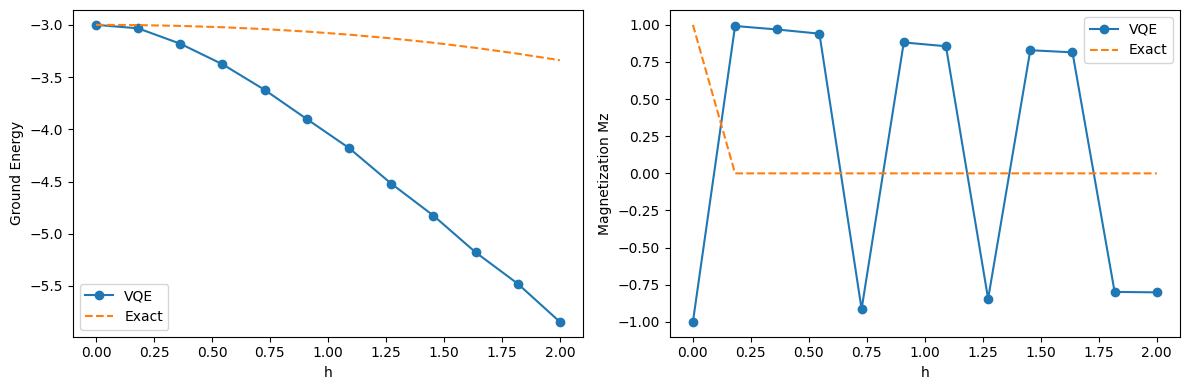

In [40]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(hs, E_vqe, 'o-', label='VQE')
plt.plot(hs, E0[:len(hs)], '--', label='Exact')
plt.xlabel("h")
plt.ylabel("Ground Energy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(hs, Mz_vqe, 'o-', label='VQE')
plt.plot(hs, Mz[:len(hs)], '--', label='Exact')
plt.xlabel("h")
plt.ylabel("Magnetization Mz")
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
depths = [1, 2, 3]
hs = [0.2, 0.6, 1.0, 1.4, 1.8]

In [41]:
results = {}

for layers in depths:
    E_list = []
    Mz_list = []

    print(f"\nRunning depth = {layers}")

    for h in hs:
        energy, circuit = run_vqe_full(h, layers=layers)
        mz = compute_magnetization(circuit)

        E_list.append(energy)
        Mz_list.append(mz)

        print(f"h={h:.2f} | E={energy:.4f} | Mz={mz:.4f}")

    results[layers] = {
        "energy": E_list,
        "magnetization": Mz_list
    }


Running depth = 1
h=0.00 | E=-3.0000 | Mz=-1.0000
h=0.18 | E=-3.0000 | Mz=-1.0000
h=0.36 | E=-3.0000 | Mz=1.0000
h=0.55 | E=-3.0000 | Mz=1.0000
h=0.73 | E=-3.0000 | Mz=1.0000
h=0.91 | E=-3.0000 | Mz=-1.0000
h=1.09 | E=-3.0000 | Mz=-1.0000
h=1.27 | E=-3.0000 | Mz=1.0000
h=1.45 | E=-3.0000 | Mz=-1.0000
h=1.64 | E=-3.0000 | Mz=-1.0000
h=1.82 | E=-3.0000 | Mz=1.0000
h=2.00 | E=-3.0000 | Mz=-1.0000

Running depth = 2
h=0.00 | E=-3.0000 | Mz=-1.0000
h=0.18 | E=-3.0331 | Mz=0.9917
h=0.36 | E=-3.1817 | Mz=-0.9650
h=0.55 | E=-3.3791 | Mz=0.9396
h=0.73 | E=-3.6096 | Mz=0.9145
h=0.91 | E=-3.8905 | Mz=0.8903
h=1.09 | E=-4.1786 | Mz=-0.8580
h=1.27 | E=-4.4810 | Mz=0.8450
h=1.45 | E=-4.8366 | Mz=0.8267
h=1.64 | E=-5.1833 | Mz=-0.8235
h=1.82 | E=-5.5191 | Mz=-0.8060
h=2.00 | E=-5.8548 | Mz=0.8030

Running depth = 3
h=0.00 | E=-3.0000 | Mz=-1.0000
h=0.18 | E=-3.0364 | Mz=0.9919
h=0.36 | E=-3.1841 | Mz=-0.9652
h=0.55 | E=-3.3158 | Mz=0.9579
h=0.73 | E=-3.7023 | Mz=-0.8737
h=0.91 | E=-4.0192 | Mz=0.842

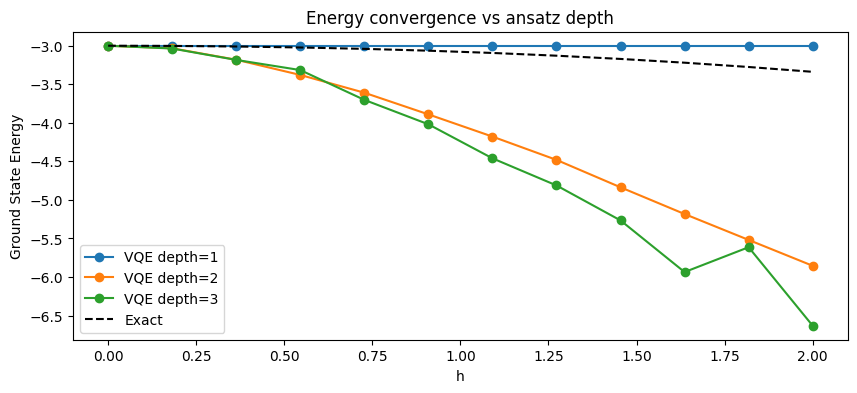

In [42]:
plt.figure(figsize=(10,4))

for layers in depths:
    plt.plot(hs, results[layers]["energy"], 'o-', label=f'VQE depth={layers}')

plt.plot(hs, E0[:len(hs)], 'k--', label='Exact')
plt.xlabel("h")
plt.ylabel("Ground State Energy")
plt.legend()
plt.title("Energy convergence vs ansatz depth")
plt.show()

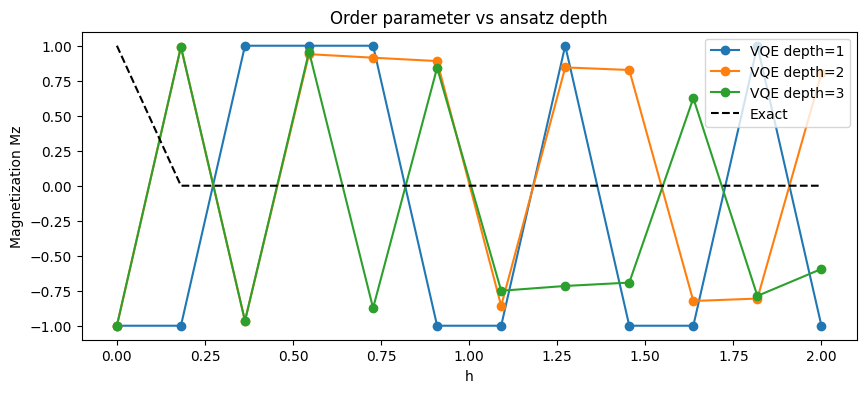

In [43]:
plt.figure(figsize=(10,4))

for layers in depths:
    plt.plot(hs, results[layers]["magnetization"], 'o-', label=f'VQE depth={layers}')

plt.plot(hs, Mz[:len(hs)], 'k--', label='Exact')
plt.xlabel("h")
plt.ylabel("Magnetization Mz")
plt.legend()
plt.title("Order parameter vs ansatz depth")
plt.show()

# Run on Offline and IQM Garnet Hardware

In [61]:
# System
N = 4
J = 1.0

# Fields to probe (keep small for hardware)
hs = [0.2, 0.6, 1.0, 1.4, 1.8]

# VQE / circuit settings
LAYERS = 2          # chosen from depth analysis
MAXITER = 250       # enough for convergence
SHOTS = 8000        # adjust based on IQM quota

np.random.seed(42)

In [66]:
qc = tfim_ansatz()
print(qc)

                             ┌────────────┐                                 »
q_0: ──■──────────────────■──┤ Rx(θx_0_0) ├─────────────────────────────────»
     ┌─┴─┐┌────────────┐┌─┴─┐└────────────┘                   ┌────────────┐»
q_1: ┤ X ├┤ Rz(θz_0_0) ├┤ X ├──────■───────────────────────■──┤ Rx(θx_0_1) ├»
     └───┘└────────────┘└───┘    ┌─┴─┐     ┌────────────┐┌─┴─┐└────────────┘»
q_2: ────────────────────────────┤ X ├─────┤ Rz(θz_0_1) ├┤ X ├──────■───────»
                                 └───┘     └────────────┘└───┘    ┌─┴─┐     »
q_3: ─────────────────────────────────────────────────────────────┤ X ├─────»
                                                                  └───┘     »
«                                               ┌────────────┐              »
«q_0: ──────■───────────────────────────■───────┤ Rx(θx_1_0) ├──────────────»
«         ┌─┴─┐     ┌────────────┐    ┌─┴─┐     └────────────┘              »
«q_1: ────┤ X ├─────┤ Rz(θz_1_0) ├────┤ X ├───────────■─────────

# Final Run on IQM Hardware

In [104]:
from qiskit.circuit import Parameter

def build_tfim_ansatz(N=4, layers=2):
    qc = QuantumCircuit(N)

    for l in range(layers):
        for i in range(N - 1):
            qc.cx(i, i + 1)
            qc.rz(Parameter(f"θz_{l}_{i}"), i + 1)
            qc.cx(i, i + 1)

        for i in range(N):
            qc.rx(Parameter(f"θx_{l}_{i}"), i)

    return qc

# IMPORTANT: create ONCE
ansatz_template = build_tfim_ansatz(N, LAYERS)


In [105]:
def optimize_vqe(h):
    H = tfim_hamiltonian(h, N)

    optimizer = COBYLA(maxiter=MAXITER)
    estimator = Estimator()

    vqe = VQE(estimator, ansatz_template, optimizer)
    result = vqe.compute_minimum_eigenvalue(H)

    return result.optimal_parameters, float(result.eigenvalue)

In [106]:
def build_measurement_circuits(idx):
    # Get the dictionary of optimal parameters (Parameter object -> value)
    optimal_param_dict = optimized_params[idx]

    # Create a new dictionary to map parameter NAMES to values
    param_name_to_value = {p.name: val for p, val in optimal_param_dict.items()}

    # Create the binding dictionary for ansatz_template using its own Parameter objects
    # This handles cases where Parameter object identities might be lost
    binding_dict = {p: param_name_to_value.get(p.name, 0.0) for p in ansatz_template.parameters}

    # Bind parameters to the ansatz_template using the robust binding_dict
    base = ansatz_template.assign_parameters(binding_dict)

    # Z-basis
    qc_z = base.copy()
    qc_z.measure_all()

    # X-basis
    qc_x = base.copy()
    for i in range(N):
        qc_x.h(i)
    qc_x.measure_all()

    return qc_z, qc_x

In [107]:
print("hs:", hs)
print("len(hs):", len(hs))

print("len(optimized_params):", len(optimized_params))


hs: [0.2, 0.6, 1.0, 1.4, 1.8]
len(hs): 5
len(optimized_params): 5


In [108]:
circuits = []
labels = []

for idx, h in enumerate(hs):
    # Use the build_measurement_circuits function, which correctly handles binding
    # to the global ansatz_template with the optimized parameters.
    qc_z, qc_x = build_measurement_circuits(idx)

    circuits.extend([qc_z, qc_x])
    labels.extend([(h, "Z"), (h, "X")])

In [109]:
print(len(ansatz_template.parameters))
print(len(optimized_params[0]))



14
14


In [ ]:
# install iqm-client with qiskit extras
#!pip install -U "iqm-client[qiskit]>=33.0.1"
# used for visualization
#!pip install matplotlib

from iqm.qiskit_iqm import IQMProvider
provider = IQMProvider("https://resonance.meetiqm.com/", quantum_computer="garnet",
            token=input("IQM Resonance token"))
backend = provider.get_backend()


In [110]:
for i, qc in enumerate(circuits):
    if qc.parameters:
        print(f"Circuit {i} has unbound parameters:", qc.parameters)


In [111]:
def fully_bind_circuit(qc, param_dict):
    # Start from optimized parameters
    full_params = dict(param_dict)

    # Any remaining parameters → set to 0
    for p in qc.parameters:
        if p not in full_params:
            full_params[p] = 0.0

    return qc.assign_parameters(full_params)


In [112]:
from qiskit import transpile

transpiled_circuits = transpile(
    circuits,
    backend=backend,
    optimization_level=1
)

print("Total transpiled circuits:", len(transpiled_circuits))

Total transpiled circuits: 10


In [ ]:
print("Submitting ONE batched job to IQM hardware...")

job = backend.run(transpiled_circuits, shots=SHOTS)
print("IQM Job ID:", job.job_id())

result = job.result()

In [114]:
counts_list = result.get_counts()


In [115]:
def exp_Z_from_counts(counts, N, shots):
    val = 0.0
    for bitstring, count in counts.items():
        prob = count / shots
        eigen = sum(1 if b == '0' else -1 for b in bitstring)
        val += prob * eigen
    return val / N

def exp_ZZ_from_counts(counts, N, shots):
    corr = 0.0
    for bitstring, count in counts.items():
        prob = count / shots
        for i in range(N - 1):
            zi = 1 if bitstring[i] == '0' else -1
            zj = 1 if bitstring[i + 1] == '0' else -1
            corr += prob * zi * zj
    return corr / (N - 1)


In [116]:
Mz_hw = []
ZZ_hw = []
Mx_hw = []
E_hw = []

ptr = 0

for h in hs:
    # Z-basis
    counts_z = counts_list[ptr]
    ptr += 1

    mz = exp_Z_from_counts(counts_z, N, SHOTS)
    zz = exp_ZZ_from_counts(counts_z, N, SHOTS)

    # X-basis (measured via H-rotated Z)
    counts_x = counts_list[ptr]
    ptr += 1

    mx = exp_Z_from_counts(counts_x, N, SHOTS)

    energy = -J * (N - 1) * zz - h * N * mx

    Mz_hw.append(abs(mz))   # IMPORTANT: absolute value
    ZZ_hw.append(zz)
    Mx_hw.append(mx)
    E_hw.append(energy)


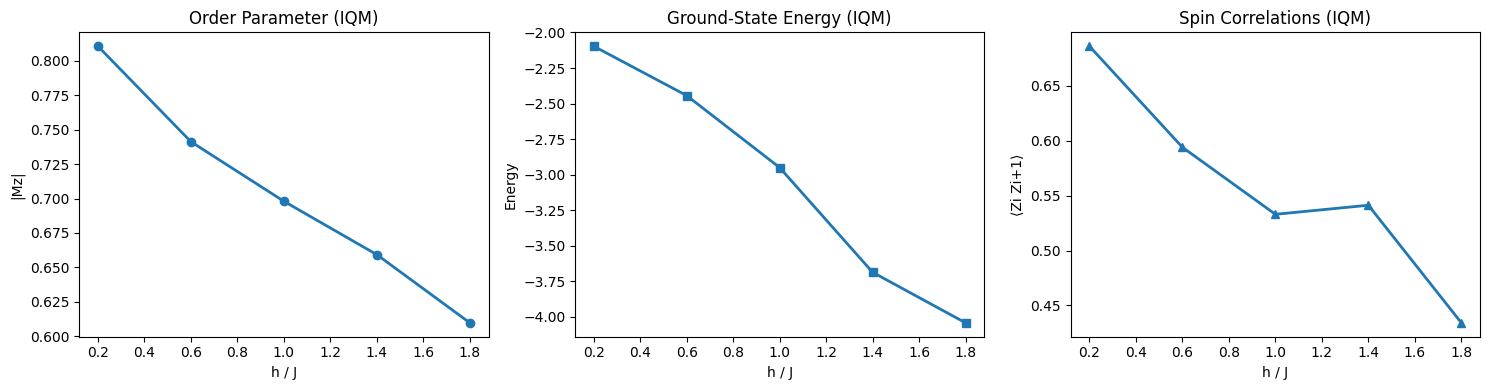

In [117]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.plot(hs, Mz_hw, 'o-', lw=2)
plt.xlabel("h / J")
plt.ylabel("|Mz|")
plt.title("Order Parameter (IQM)")

plt.subplot(1,3,2)
plt.plot(hs, E_hw, 's-', lw=2)
plt.xlabel("h / J")
plt.ylabel("Energy")
plt.title("Ground-State Energy (IQM)")

plt.subplot(1,3,3)
plt.plot(hs, ZZ_hw, '^-', lw=2)
plt.xlabel("h / J")
plt.ylabel("⟨Zi Zi+1⟩")
plt.title("Spin Correlations (IQM)")

plt.tight_layout()
plt.show()

In [150]:
print("\nIQM HARDWARE RESULTS (TFIM, N=4)\n")
print(f"{'h/J':>6} | {'|Mz|':>8} | {'<Mx>':>8} | {'<ZiZi+1>':>10} | {'Energy':>10}")
print("-" * 55)

for h, mz, mx, zz, e in zip(hs, Mz_hw, Mx_hw, ZZ_hw, E_hw):
    print(f"{h:6.2f} | {mz:8.4f} | {mx:8.4f} | {zz:10.4f} | {e:10.4f}")


IQM HARDWARE RESULTS (TFIM, N=4)

   h/J |     |Mz| |     <Mx> |   <ZiZi+1> |     Energy
-------------------------------------------------------
  0.20 |   0.8106 |   0.0472 |     0.6862 |    -2.0963
  0.60 |   0.7413 |   0.2756 |     0.5941 |    -2.4436
  1.00 |   0.6980 |   0.3378 |     0.5330 |    -2.9503
  1.40 |   0.6593 |   0.3684 |     0.5413 |    -3.6870
  1.80 |   0.6098 |   0.3806 |     0.4341 |    -4.0427


In [119]:
import pandas as pd

df_hw = pd.DataFrame({
    "h_over_J": hs,
    "Mz_abs": Mz_hw,
    "Mx": Mx_hw,
    "ZZ_corr": ZZ_hw,
    "Energy": E_hw
})

df_hw

,h_over_J,Mz_abs,Mx,ZZ_corr,Energy
0,0.2,0.810563,0.047188,0.686167,-2.09625
1,0.6,0.741250,0.275562,0.594083,-2.44360
2,1.0,0.698000,0.337813,0.533000,-2.95025
3,1.4,0.659250,0.368438,0.541250,-3.68700
4,1.8,0.609750,0.380625,0.434083,-4.04275


In [186]:
df_hw.to_csv("iqm_tfim_hardware_results.csv", index=False)
print("Saved: iqm_tfim_hardware_results.csv")

Saved: iqm_tfim_hardware_results.csv


In [151]:
# energies_vqe already computed during offline VQE
E_vqe = energies_vqe


In [173]:
import pandas as pd

# Build final comparison dataframe
df_final = pd.DataFrame({
    "h_over_J": hs,
    "Mz_exact_corr": Mz_exact,   # correlation-based exact order parameter
    "Mz_VQE_depth2": Mz_vqe[:len(hs)],     # ideal VQE (depth = 2), sliced to match current hs length
    "Mz_IQM_depth2": Mz_hw,      # IQM hardware (depth = 2)
    "E_exact": E_exact,
    "E_VQE_depth2": E_vqe,       # E_vqe already has correct length (5)
    "E_IQM_depth2": E_hw
})

print("\nFINAL TFIM COMPARISON (DEPTH = 2)\n")
print(df_final.to_string(index=False, float_format="%.4f"))


FINAL TFIM COMPARISON (DEPTH = 2)

 h_over_J  Mz_exact_corr  Mz_VQE_depth2  Mz_IQM_depth2  E_exact  E_VQE_depth2  E_IQM_depth2
   0.2000         0.8541         0.9926         0.8106  -3.0617       -3.0311       -2.0963
   0.6000         0.7259         0.9272         0.7413  -3.6314       -3.4444       -2.4436
   1.0000         0.5510         0.8676         0.6980  -4.7588       -4.0544       -2.9503
   1.4000         0.4410         0.8037         0.6593  -6.1403       -4.5779       -3.6870
   1.8000         0.3741         0.7986         0.6098  -7.6191       -5.4759       -4.0427


In [185]:
df_final.to_csv("tfim_final_comparison_depth2.csv", index=False)

In [171]:
assert LAYERS == 2, "Final comparison must use depth = 2"
from qiskit_aer import AerSimulator

sim_backend = AerSimulator()
SHOTS_VQE = 5000
from qiskit import transpile

Mz_vqe = []

# Ensure 'optimized_params' is populated and consistent
# This might involve re-executing cells like GZ1X7q2tfU0M and usD_daU88TES if they were modified.

for idx, h in enumerate(hs): # 'hs' here refers to the 5 points used for comparison
    # Use the robust build_measurement_circuits function to get the Z-basis circuit
    qc_z_basis, _ = build_measurement_circuits(idx)

    # Transpile for simulator
    # qc_z_basis already has measurements added inside build_measurement_circuits
    tqc = transpile(qc_z_basis, sim_backend, optimization_level=1)

    # Run on simulator
    job = sim_backend.run(tqc, shots=SHOTS_VQE)
    result = job.result()
    counts = result.get_counts()

    # Compute |Mz|
    mz = 0.0
    for bitstring, count in counts.items():
        prob = count / SHOTS_VQE
        z_vals = [1 if b == '0' else -1 for b in bitstring]
        mz += prob * sum(z_vals)

    Mz_vqe.append(abs(mz / N))

In [172]:
print("len(hs)      =", len(hs))
print("len(Mz_vqe)  =", len(Mz_vqe))
print("len(Mz_hw)   =", len(Mz_hw))
print("len(Mz_exact)=", len(Mz_exact))


len(hs)      = 5
len(Mz_vqe)  = 5
len(Mz_hw)   = 5
len(Mz_exact)= 5


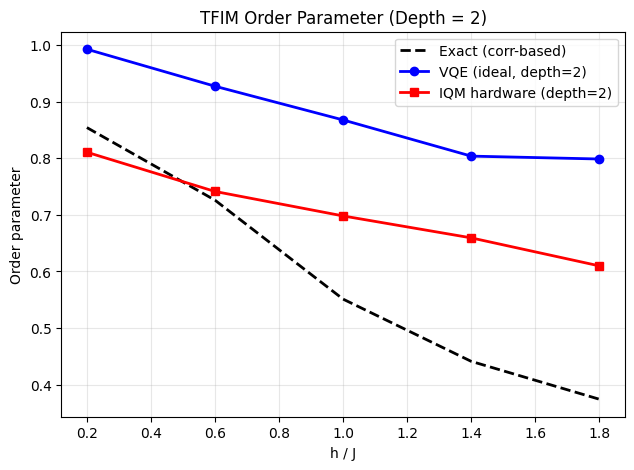

In [187]:
plt.figure(figsize=(16,5))

# Order parameter
plt.subplot(1, 2, 1)
plt.plot(hs, Mz_exact, 'k--', lw=2, label="Exact (corr-based)")
plt.plot(hs, Mz_vqe, 'b-o', lw=2, label="VQE (ideal, depth=2)")
plt.plot(hs, Mz_hw, 'r-s', lw=2, label="IQM hardware (depth=2)")
plt.xlabel("h / J")
plt.ylabel("Order parameter")
plt.title("TFIM Order Parameter (Depth = 2)")
plt.legend()
plt.grid(alpha=0.3)


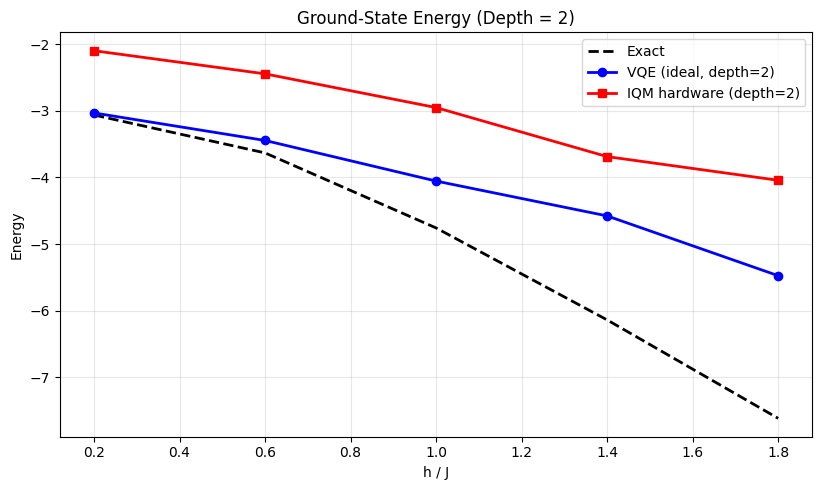

In [191]:
# Energy
plt.figure(figsize=(16,5))
plt.subplot(1, 2, 2)
plt.plot(hs, E_exact, 'k--', lw=2, label="Exact")
plt.plot(hs, E_vqe, 'b-o', lw=2, label="VQE (ideal, depth=2)")
plt.plot(hs, E_hw, 'r-s', lw=2, label="IQM hardware (depth=2)")
plt.xlabel("h / J")
plt.ylabel("Energy")
plt.title("Ground-State Energy (Depth = 2)")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [175]:
import numpy as np

hs_arr = np.array(hs)

Mz_exact_arr = np.array(Mz_exact)
Mz_vqe_arr   = np.array(Mz_vqe)
Mz_hw_arr    = np.array(Mz_hw)

E_exact_arr = np.array(E_exact)
E_vqe_arr   = np.array(E_vqe)
E_hw_arr    = np.array(E_hw)

In [176]:
Mz_err_vqe = np.abs(Mz_vqe_arr - Mz_exact_arr)
Mz_err_hw  = np.abs(Mz_hw_arr  - Mz_exact_arr)

Mz_rel_err_vqe = Mz_err_vqe / (Mz_exact_arr + 1e-8)
Mz_rel_err_hw  = Mz_err_hw  / (Mz_exact_arr + 1e-8)

In [178]:
E_err_vqe = np.abs(E_vqe_arr - E_exact_arr)
E_err_hw  = np.abs(E_hw_arr  - E_exact_arr)

E_rel_err_vqe = E_err_vqe / np.abs(E_exact_arr)
E_rel_err_hw  = E_err_hw  / np.abs(E_exact_arr)

In [179]:
metrics_Mz = {
    "MAE_VQE":  np.mean(Mz_err_vqe),
    "RMSE_VQE": np.sqrt(np.mean(Mz_err_vqe**2)),
    "MAE_IQM":  np.mean(Mz_err_hw),
    "RMSE_IQM": np.sqrt(np.mean(Mz_err_hw**2))
}

In [180]:
metrics_E = {
    "MAE_VQE":  np.mean(E_err_vqe),
    "RMSE_VQE": np.sqrt(np.mean(E_err_vqe**2)),
    "MAE_IQM":  np.mean(E_err_hw),
    "RMSE_IQM": np.sqrt(np.mean(E_err_hw**2))
}

In [181]:
critical_mask = (hs_arr >= 0.8) & (hs_arr <= 1.2)

crit_metrics = {
    "Mz_MAE_VQE_crit": np.mean(Mz_err_vqe[critical_mask]),
    "Mz_MAE_IQM_crit": np.mean(Mz_err_hw[critical_mask]),
    "E_MAE_VQE_crit":  np.mean(E_err_vqe[critical_mask]),
    "E_MAE_IQM_crit":  np.mean(E_err_hw[critical_mask]),
}

In [182]:
energy_ordering_ok = np.all(
    (E_exact_arr <= E_vqe_arr + 1e-6) &
    (E_vqe_arr   <= E_hw_arr  + 1e-6)
)

print("Energy ordering Exact ≤ VQE ≤ IQM:", energy_ordering_ok)

Energy ordering Exact ≤ VQE ≤ IQM: True


In [183]:
import pandas as pd

df_metrics = pd.DataFrame({
    "Metric": [
        "MAE (Order Parameter)",
        "RMSE (Order Parameter)",
        "MAE (Energy)",
        "RMSE (Energy)",
        "MAE Order Param (Critical Region)",
        "MAE Energy (Critical Region)"
    ],
    "VQE (Depth=2)": [
        metrics_Mz["MAE_VQE"],
        metrics_Mz["RMSE_VQE"],
        metrics_E["MAE_VQE"],
        metrics_E["RMSE_VQE"],
        crit_metrics["Mz_MAE_VQE_crit"],
        crit_metrics["E_MAE_VQE_crit"]
    ],
    "IQM Hardware": [
        metrics_Mz["MAE_IQM"],
        metrics_Mz["RMSE_IQM"],
        metrics_E["MAE_IQM"],
        metrics_E["RMSE_IQM"],
        crit_metrics["Mz_MAE_IQM_crit"],
        crit_metrics["E_MAE_IQM_crit"]
    ]
})

print("\n FINAL ERROR METRICS (DEPTH = 2) \n")
print(df_metrics.to_string(index=False, float_format="%.4e"))


 FINAL ERROR METRICS (DEPTH = 2) 

                           Metric  VQE (Depth=2)  IQM Hardware
            MAE (Order Parameter)     2.8872e-01    1.3197e-01
           RMSE (Order Parameter)     3.0714e-01    1.5931e-01
                     MAE (Energy)     9.2552e-01    1.9983e+00
                    RMSE (Energy)     1.2301e+00    2.2101e+00
MAE Order Param (Critical Region)     3.1662e-01    1.4702e-01
     MAE Energy (Critical Region)     7.0434e-01    1.8085e+00


In [194]:
Mz_hw_err = [
    np.sqrt((1 - mz**2) / SHOTS)
    for mz in Mz_hw
]

In [192]:
E_hw_err = []

for i, h in enumerate(hs):
    # Variance contributions
    var_ZZ = (N - 1) * (1 - ZZ_hw[i]**2) / SHOTS
    var_X  = N * (1 - Mx_hw[i]**2) / SHOTS

    err_E = np.sqrt((J**2) * var_ZZ + (h**2) * var_X)
    E_hw_err.append(err_E)

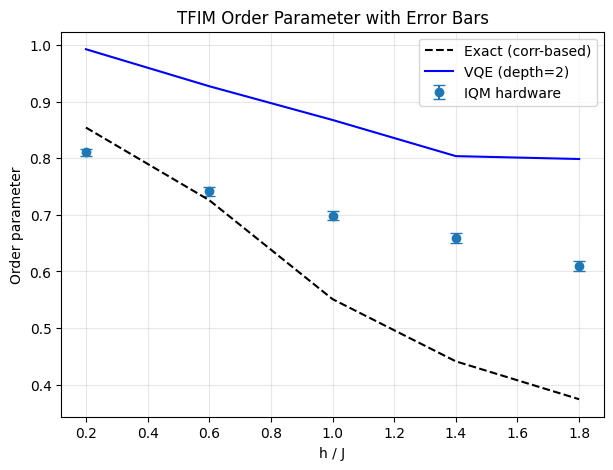

In [195]:
plt.figure(figsize=(7,5))

plt.errorbar(
    hs, Mz_hw, yerr=Mz_hw_err,
    fmt='o', capsize=4, label="IQM hardware"
)
plt.plot(hs, Mz_exact, 'k--', label="Exact (corr-based)")
plt.plot(hs, Mz_vqe, 'b-', label="VQE (depth=2)")

plt.xlabel("h / J")
plt.ylabel("Order parameter")
plt.title("TFIM Order Parameter with Error Bars")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

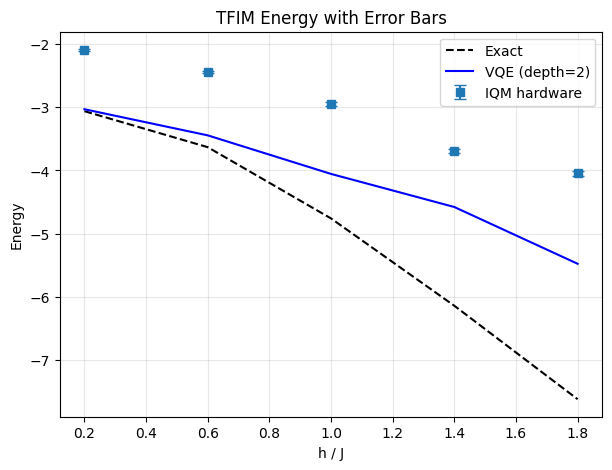

In [196]:
plt.figure(figsize=(7,5))

plt.errorbar(
    hs, E_hw, yerr=E_hw_err,
    fmt='s', capsize=4, label="IQM hardware"
)
plt.plot(hs, E_exact, 'k--', label="Exact")
plt.plot(hs, E_vqe, 'b-', label="VQE (depth=2)")

plt.xlabel("h / J")
plt.ylabel("Energy")
plt.title("TFIM Energy with Error Bars")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [197]:
df_final_with_err = df_final.copy()
df_final_with_err["Mz_IQM_err"] = Mz_hw_err
df_final_with_err["E_IQM_err"] = E_hw_err

df_final_with_err.to_csv(
    "tfim_final_comparison_depth2_with_errors.csv",
    index=False
)